In [90]:
import pandas as pd
import csv
import numpy as np
import string, os 
import math
from matplotlib import pyplot as plt
import re
import ast
import itertools
import pickle

import matplotlib.pyplot as plt
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import rdmolops

import ast
import re

import codecs
# from SmilesPE.spe2vec import *
# from SmilesPE.tokenizer import *

from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor 

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from keras import models 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast
from SmilesPE.pretokenizer import atomwise_tokenizer
import codecs
from SmilesPE.tokenizer import *
from SmilesPE.spe2vec import *
from SmilesPE.pretokenizer import kmer_tokenizer

from sklearn.model_selection import train_test_split

from rdkit.Chem import AllChem as Chem
# import deepsmiles
# import selfies as sf

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
df = pd.read_csv('../data/VEGF2_ChEMBL28-10980_pic50_noDuplicate_canSmiles_sln_deepSmiles_selfies_inchi.csv',sep=',')

In [6]:
linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']
for notName in linearNotation_names:
    df[notName+'_length'] = df[notName].str.len()
print(df.shape)
# canonical_smiles_length
dfClean = df.loc[(df['canonical_smiles_length'] >30) & (df['canonical_smiles_length']<80)]
print(dfClean.shape)

(7159, 11)
(7044, 11)


### Pomocne funkce

In [79]:
# kontrola, rozdeleni data tak je vzdy stejne i kdyz pouziji data pro jiny chem. lin. zapis
def splitData(list_token, ys, RANDOM_STATE):  
    X_train, X_test, y_train, y_test = train_test_split(list_token, ys, test_size=0.2, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE) # 0.25 x 0.8 = 0.2
    unique= set(list(itertools.chain.from_iterable(X_train)))
    n_unique=len(unique)
    max_index = max(unique)
    if(n_unique > max_index):
        vocabulary_size = n_unique + 5000
    else:
        vocabulary_size = max_index +5000
    return X_train,y_train,X_val,y_val,X_test,y_test,vocabulary_size

In [54]:
def removeBeginningInChI(chem_notation,substring):
    res = chem_notation.replace(substring,'')
    return res

In [55]:
def splitByAtomwiseTokenizer(chem_notation):
    lst=[]
    temp = atomwise_tokenizer(chem_notation)
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [56]:
def addCharAtBeginningEnd(temp):
    lst=[]
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [57]:
def tokenizationBPEChemLinearNotaion(col_name,df):
    fileName = 'data_for_tokenizer/tokenizer-wiki_'+str(col_name)+'.json' 
    fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file=fileName)
    return df[col_name].apply(lambda chem_notaion: fast_tokenizer.tokenize(str(chem_notaion)))

In [58]:
def addCharacterStartEndSequenceSplitByCharacters(chem_notation):
    chem_notation = "^" + chem_notation + "$"
    return [c for c in chem_notation]

In [59]:
def tokenizeChemNotation(chem_notation,col_name): 
    spe_vob= codecs.open('SPE_ChEMBL_'+str(col_name)+'.txt')
    spe = SPE_Tokenizer(spe_vob)
    lst = spe.tokenize(chem_notation)
    lst = lst.split(' ')
    return lst

In [60]:
def splitByKmerTokenizer(chem_notation):
    lst=[]
    temp = kmer_tokenizer(chem_notation, ngram=4, stride=1, remove_last = False, exclusive_tokens = None)
    lst.append('^')
    for l in temp:
        lst.append(l)
    lst.append('$')
    return lst

In [61]:
# vytvorit list token id + padding 
def createListTokensId(chem_notation, vocabulary):
    token_id_list=[]
    for c in chem_notation:
        token_id_list.append(vocabulary[c])
    return token_id_list

In [ ]:
# vytvoreni modelu s tunnenim parametru
def create_modelPrams(params, max_length, vocab_size):
    n_features = 1
    # tady je treba to nastavit podle nejvyssiho indexu, jinak embedding vyhodi chybu
    # Keras LSTM model
    model = Sequential()
    model.add(Embedding(vocab_size,params['units_embedding'], input_length=max_length))

    model.add(Bidirectional(LSTM(units=params['units1'], input_shape=(max_length, n_features))))
    # model.add(LSTM(units=params['units1'], input_shape=(max_length, n_features)))
    model.add(Dropout(rate=0.5))

    # Middle layers return sequences
    for i in range(params['layers']-2):
        model.add(Dense(units=params['units2']))
        # model.add(LSTM(units=params['units2'], return_sequences=True))
        model.add(Dropout(rate=0.5))
        
    model.add(Dense(units=params['units3']))
    model.add(Dropout(rate=0.5))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam',metrics=['mse'])
    # model.summary()
    return model

In [ ]:
def tokenize(df,linearNotation_name,tokenization,lengths_lst_tokenIdxs,j):
    substring = 'InChI=1S/'
    df['inchi'] = df['inchi'].apply(lambda chem_notation: removeBeginningInChI(chem_notation,substring))
    col_name = linearNotation_name
    token_col_name = col_name+'_tokens'
    tokenIndex_col_name = col_name+'_tokenIndexList'

    if(tokenization == 'atom'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: splitByAtomwiseTokenizer(chem_notation))
    elif(tokenization == 'bpe'):
        df[token_col_name] = tokenizationBPEChemLinearNotaion(col_name,df)
        df[token_col_name] = df[token_col_name].apply(lambda lst_tokens: addCharAtBeginningEnd(lst_tokens))
    elif(tokenization == 'char'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: addCharacterStartEndSequenceSplitByCharacters(chem_notation))
    elif(tokenization == 'spe'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: tokenizeChemNotation(chem_notation,col_name))
    elif(tokenization == 'kmer'):
        df[token_col_name] = df[col_name].apply(lambda chem_notation: splitByKmerTokenizer(chem_notation))
        
    max_length = lengths_lst_tokenIdxs[tokenization][j]
    df[token_col_name] = df[token_col_name].apply(lambda x: cutVecTokens(x,max_length))
    print(max_length)
    CHEM_NOTATION_CHARS = set(df[token_col_name].apply(list).sum())
    vocabulary = {c: i+2 for i,c in enumerate(set(CHEM_NOTATION_CHARS))}
    df[tokenIndex_col_name] = df[token_col_name].apply(lambda chem_notation: createListTokensId(chem_notation, vocabulary))
    
    # padding
    res = df[tokenIndex_col_name].apply(lambda tokenIndex: tokenIndex).tolist()
    # pro kontrolu
    vector_with_padding = pad_sequences(res, maxlen=max_length, padding='post', truncating='post')
    df[tokenIndex_col_name] = [vector_with_padding[i] for i in range(len(vector_with_padding))]
    # print('\n',df[token_col_name].tolist()[0])
    # print('\n',df[tokenIndex_col_name].tolist()[0])
    return df

### Trenovani site

(7044, 11)
-----------------------------------------------------------------------------
atom
-----------------------------------------------------------------------------
bpe

inchi
130
(7044, 130)
Epoch 00151: early stopping
45/45 [==============================] - 2s 33ms/step - loss: 1.2529 - mse: 1.2529

n_patience:   40
cut_length:   130
results: [1.2528955936431885, 1.2528955936431885]
-----------------------------------------------------------------------------
char
-----------------------------------------------------------------------------
spe
-----------------------------------------------------------------------------
kmer


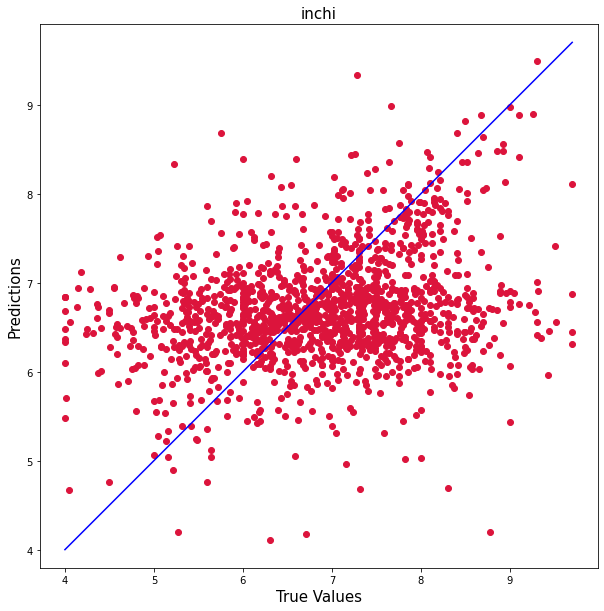

In [100]:
# budu delat postupne po tokenizacich, abych to mohla kontrolovat
#DEFINIICE PROMENNYCH
tokenization_names = ['atom','bpe','char','spe','kmer']
linearNotation_names = ['canonical_smiles','sln','deep_smiles','selfies','inchi']

params={'layers': 3, 'l_rate': 0.01, 'units1': 40, 'units2': 32, 'units3': 16, 'units_embedding': 80}  
encoding = 'tokenIndexVec'
n_patience = 40
RANDOM_STATE=42
lengths_lst_tokenIdxs = {   'atom':[60,90,65,62,160],
                            'char':[62,105,70,300,160],
                            'kmer':[60,92,65,60,160],
                            'bpe':[30,62,24,125,90],
                            'spe':[13,8,7,31,43]}
print(dfClean.shape)
ys = np.array(dfClean['value'].tolist())

# ITERATE OVER TOKENIZATION
for i in range(len(tokenization_names)):
    tokenization = tokenization_names[i]
    print('-----------------------------------------------------------------------------\n'+tokenization)
    # ITERATE OVER LINEAR CHEMICAL NOTATION
    for j in range(len(linearNotation_names)):
        chem_notation = linearNotation_names[j]
        if(not((tokenization=='bpe' and chem_notation == 'inchi'))):
            continue
        max_length = lengths_lst_tokenIdxs[tokenization][j]
        print('\n'+chem_notation)
        df_new = tokenize(dfClean.copy(),chem_notation,tokenization,lengths_lst_tokenIdxs,j)
        data = np.array(df_new[chem_notation+'_tokenIndexList'].tolist())
        print(data.shape)
        
        X_train,y_train,X_val,y_val,X_test,y_test,vocab_size = splitData(data, ys, RANDOM_STATE)
        model = create_modelPrams(params, max_length, vocab_size)
        
        # for np in n_patiences:
        startName = '../data/models/'+encoding
        bestModelName = startName +'/bestModel_otherArchitecture_'+chem_notation+'_np_'+str(n_patience)+'.h5'
        predictionsPlot_fileName = startName +'/predictionsPlot_'+chem_notation+'_np_'+str(n_patience)+'.png'

        mc = ModelCheckpoint(bestModelName, monitor='val_loss', mode='min')
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=n_patience)
        # validation_data=(X_val, y_val)
        X_train, X_val_fit, y_train, y_val_fit = train_test_split(X_train,y_train,test_size=0.2,random_state=RANDOM_STATE) # before model building
        result = model.fit(X_train, y_train, validation_data=(X_val_fit, y_val_fit),  epochs=400,verbose=0, callbacks=[es,mc])
        best_model = models.load_model(bestModelName)
        # # model prediction
        y_pred = best_model.predict(X_val)
        results_eval = best_model.evaluate(X_val, y_val)
        print('\nn_patience:  ', n_patience)
        print('cut_length:  ',max_length)
        print('results:',results_eval ,end='\n')
        plotPredictReal(y_pred,y_val,chem_notation,predictionsPlot_fileName)
        